# Rice classification using PyTorch

Welcome to my notebook, where i'm going to use the PyTorch library to train a model that can classify samples of rice based on some features.

The dataset used for this project can be found [here](https://www.kaggle.com/datasets/mssmartypants/rice-type-classification/data), on Kaggle.

The main purpose is not to be a complete data science project, with exploratory data analysis, test of diferents classification algorithms and deep analysis of the result. Instead, the main purpose is to use PyTorch with it's features to code a complete neural network that can produce a solution at the end and to observe how some validation metrics (such as accuracy and loss, specialy) vary along the training process of the neural network.

For any doubt, commentary or question, fell free to get in touch with me via [linkedin](https://www.linkedin.com/in/marcosdatadev/).

Hope you have a good day and a pleasant night!

The imports here are just for the libraries and functions that i'm going to use. Nothing fancy, but with all the necessary tools.

The 'device' at the end is to define which execution device are going to be used along the project. If the machine in use has a GPU to be used in the training phase (which makes it faster and stabler), so the GPU will be used. Otherwise, the CPU will be selected.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import  summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [2]:
df = pd.read_csv('riceClassification.csv')
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


As a said earlier, this project don't try to be optimized, so i've chosed to not give a profound look to outlier, duplicates, null values and other problems that usually occur in real life datasets.

This decision was made with their problems in mind. The main reason was the kaggle documentation that shows that this dataset is already cleansed, with no greater problems.

In [3]:
print(f'Before drop null values: {df.shape}')

df.dropna(inplace=True)
df.drop(['id'], axis=1, inplace=True)

print(f'After drop null values: {df.shape}')

Before drop null values: (18185, 12)
After drop null values: (18185, 11)


In [4]:
print(f"We have {df['Class'].nunique()} different classes on the dataset")
print(f"The frequency of each class is:\n{round(df['Class'].value_counts(normalize=True), 3)}")

We have 2 different classes on the dataset
The frequency of each class is:
Class
1    0.549
0    0.451
Name: proportion, dtype: float64


The normalization is necessary, once the parameters have a great discrepancy in range (the eccentricity, for example, goes from 0.68 to 0.97, while the convexArea goes from 2579 to 11k).

Without this, the model will naturally prioritize certain features over others. With this, all features have the same weight and importance at the beggining.

In [5]:
df_normalized = df.copy()
columns_to_normalize = df_normalized.drop(['Class'], axis=1)

for column in columns_to_normalize:
    df_normalized[column] = df_normalized[column] / max(df_normalized[column])
    
df_normalized.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1


Here, I divide the dataset in three groups: train, validation and test.

The train sub-dataset has ~70% of the values, while the validation and test has ~15% each.

In [6]:
x = np.array(df_normalized.drop(['Class'], axis=1))
y = np.array(df_normalized['Class'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [7]:
x_train_percent = x_train.shape[0]/x.shape[0] * 100
x_val_percent = x_val.shape[0]/x.shape[0] * 100
x_test_percent = x_test.shape[0]/x.shape[0] * 100

print(f"X train: {round(x_train_percent, 3)}%")
print(f"X validation: {round(x_val_percent, 3)}%")
print(f"X test: {round(x_test_percent, 3)}%")

X train: 69.997%
X validation: 15.001%
X test: 15.001%


Here, I create the 'dataset' class, which inherits from the PyTorch 'Dataset' class.

The new class aims to encapsulate the data in a format compatible with the DataLoader, mainly for the training phase with mini-batches later on.

X and Y are now PyTorch tensors in float32 format. This conversion uses the 'device' set at the beginning of the program, which varies depending on the user's computer. Remember that if the user has a GPU available, this conversion will be processed by the GPU. Otherwise, it will be done by the CPU (which is slower, but works perfectly).

In [8]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [9]:
training_data = dataset(
    x_train, 
    y_train
)

validation_data = dataset(
    x_val, 
    y_val
)

testing_data = dataset(
    x_test, 
    y_test
)

Here, the DataLoader defines the batch size used to train the model. In this case, the size is 8, which means that, in each iteraction of the neural network, 8 samples of data will be passed for the training. In each step, the neural network will try to calculate the class of each sample of this pack of 8. The errors will be backpropagated and will be used to refine the model, recalculating the weights and biases for a better calculation on the next phase.

For a better understanding of backpropagation and how it works, see [this video of 3Blue1Brown](https://www.youtube.com/watch?v=Ilg3gGewQ5U) which explains perfectly and in easy terms what occurs behind the curtains

In [10]:
train_dataloader = DataLoader(
    training_data, 
    batch_size=8, 
    shuffle=True
)

validation_dataloader = DataLoader(
    validation_data, 
    batch_size=8, 
    shuffle=True
)

test_dataloader = DataLoader(
    testing_data, 
    batch_size=8, 
    shuffle=True
)

Here we have a sample of what is in the DataLoader:

Each X is composed of 10 numbers, between 0 and 1 (since we normalized all the values). This numbers represents each feature of the rice sample. The Y vector is the label vector, and shows to wich class each sample belongs. In this case, we can see that the first 4 samples was labeled in class 1 and the last 4 in the class 0. There's 8 samples in each batch for this size was defined back then. We could set this value any number we wanted, but 8 is a good number for now.

In [11]:
for x, y in train_dataloader:
    print(x)
    print('-' * 15)
    print(y)
    break

tensor([[0.3922, 0.6285, 0.5447, 0.9522, 0.3705, 0.6262, 0.6355, 0.5162, 0.8072,
         0.6546],
        [0.5672, 0.7904, 0.6321, 0.9649, 0.5409, 0.7531, 0.8618, 0.6467, 0.7436,
         0.7095],
        [0.6843, 0.9020, 0.6623, 0.9761, 0.6484, 0.8272, 0.5989, 0.7196, 0.7248,
         0.7726],
        [0.5635, 0.8085, 0.6092, 0.9729, 0.5379, 0.7506, 0.6875, 0.6537, 0.7230,
         0.7530],
        [0.9407, 0.9069, 0.9031, 0.9244, 0.9011, 0.9699, 0.6937, 0.7899, 0.8268,
         0.5698],
        [0.8781, 0.8879, 0.8667, 0.9290, 0.8437, 0.9370, 0.6182, 0.7655, 0.8218,
         0.5813],
        [0.8887, 0.8609, 0.8988, 0.9128, 0.8504, 0.9427, 0.8100, 0.7517, 0.8626,
         0.5434],
        [0.9191, 0.8940, 0.8953, 0.9231, 0.8812, 0.9587, 0.7375, 0.7735, 0.8424,
         0.5665]])
---------------
tensor([1., 1., 1., 1., 0., 0., 0., 0.])


Here is where the magic happens! The model is created in this class MyModel, which inherits the class nn.Module. Here we set the number of layers, their type, the number of hidden neurons, the activation function and the order of execution.

As we can see, there's one input_layer with 10 neurons from input and 10 hidden neurons.

But why 10 neurons from input, you can ask yourself. The answer is simple: since or dataset is made of 10 feature, the neural network need to have 10 input neurons, one for each feature. If we have less than 10, some features will not be 'seen' by our model. And if we have more than 10, we will create a model more complex than necessary, with unnecessary complexity.

In [ ]:
HIDDEN_NEURONS = 10

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.input_layer = nn.Linear(x.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    
model = MyModel().to(device)

And here is the summary of our model. 2 layers for training and 1 exit layer. The layers of training are two linear models (on the form y=ax+b) and the exit layer uses the sigmoid function to convert the final value to something between 0 and 1.

The first layer receives 10 inputs (for the 10 features of the dataset) and calculates 10 inner neurons (in a total of 100 operations), plus the 10 biases (one for each neuron), making a total of 110 parameters.

The second layer receives the 10 outputs from the first layer and create a single exit, with a probability that indicates the chance of the sample belong to the class 0 (and with a basic operation, the chance to belong to class 1).

The final step is the sigmoid function, that maps the value from the second class to something between 0 and 1.

In [13]:
summary(model, (x.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Here we have two functions: the BCELoss (or Binary Cross Entropy) is a loss function usually applied to binary classification (wich is our case here).

The Adam otimizer is the function we will use for the backpropagation phase, making some adjusts to the weights and biases to make the neural network more accurate in each step.

In [14]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

And now, finally, we train our network!

The 'epochs' is the number of times that our model will be executed. 10 times means that the neural network (or NN) will take the dataset (one batch at time) and try to calculate it's result. After this, the errors will be used to recalculate the weights and biases and them the model will run again, one batch at time. This process will repeat 10 times (since the dataset is small, both in rows and in features), and the final result will be our final model.

At the end we can see the values of the accuracy and the loss function for each epoch. And as we can see, the values don't change much after 2 or 3 iterations. The loss function converges to 0 and the accuracy converges to 100, wich means that our model is getting better and better, but never perfect (wich is paradoxically great, for a perfect score in training data usualy means overfitting and a terrible score in test, or real world, data).

In [15]:
total_acc_train_plot = []
total_loss_train_plot = []

total_acc_validation_plot = []
total_loss_validation_plot = []

epochs = 10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    
    for data in train_dataloader:
        inputs, labels = data    
        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()
        acc = ((prediction).round() == labels).sum().item()
        total_acc_train += acc
        
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data
            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)
            total_loss_val += batch_loss.item()
            acc = ((prediction).round() == labels).sum().item()
            total_acc_val += acc
            
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))
    
    print(f"Epoch number {epoch+1}\n\
        Train loss: {round(total_loss_train/1000, 4)}\n\
        Train accuracy: {round(total_acc_train/training_data.__len__() * 100, 4)}\n\
        Validation loss: {round(total_loss_val/1000, 4)}\n\
        Validation accuracy: {round(total_acc_val/validation_data.__len__() * 100, 4)}")

Epoch number 1
        Train loss: 0.6065
        Train accuracy: 91.7904
        Validation loss: 0.0471
        Validation accuracy: 97.7273
Epoch number 2
        Train loss: 0.1339
        Train accuracy: 98.5466
        Validation loss: 0.0227
        Validation accuracy: 98.2405
Epoch number 3
        Train loss: 0.0841
        Train accuracy: 98.6095
        Validation loss: 0.0188
        Validation accuracy: 98.0938
Epoch number 4
        Train loss: 0.071
        Train accuracy: 98.6173
        Validation loss: 0.0172
        Validation accuracy: 98.3871
Epoch number 5
        Train loss: 0.067
        Train accuracy: 98.6173
        Validation loss: 0.0176
        Validation accuracy: 98.1305
Epoch number 6
        Train loss: 0.0651
        Train accuracy: 98.7352
        Validation loss: 0.0165
        Validation accuracy: 98.3504
Epoch number 7
        Train loss: 0.0647
        Train accuracy: 98.688
        Validation loss: 0.0165
        Validation accuracy: 98.3504
Ep

In [18]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in test_dataloader:
        inputs, labels = data
        prediction = model(inputs).squeeze(1)
        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test
        acc = ((prediction).round() == labels).sum().item()
        
        total_acc_test += acc
        
print(f"Accuracy: {round(total_acc_test/testing_data.__len__() * 100, 4)}%")

Accuracy: 98.5337%


Finally, we can see the plots that shows us the process of training: the first epoch shows a model with low accuracy (~91%) and high loss (~0.6). But with time, and training, the model get better and better, reaching a loss close to 0 and a accuracy close to 99%.

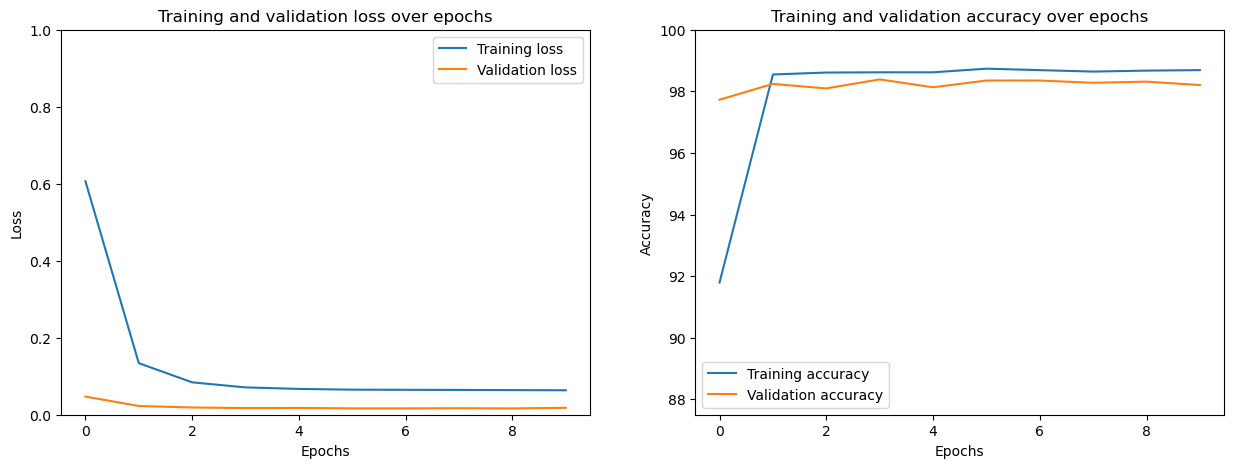

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].plot(total_loss_train_plot, label='Training loss')
ax[0].plot(total_loss_validation_plot, label='Validation loss')
ax[0].set_title('Training and validation loss over epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim((0, 1))
ax[0].legend()

ax[1].plot(total_acc_train_plot, label='Training accuracy')
ax[1].plot(total_acc_validation_plot, label='Validation accuracy')
ax[1].set_title('Training and validation accuracy over epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim((87.5, 100))
ax[1].legend()

plt.show()